In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
uploaded = files.upload()

Saving telecom_combined.csv to telecom_combined.csv


## Step 1

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("telecom_combined.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

# Convert date to datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['service_provider', 'circle', 'date'])

# Function to create churn targets
def create_churn_targets(df):
    df_churn = df.copy()

    # Month-over-month % change in subscribers for each service_provider-circle pair
    df_churn['subscriber_change'] = (
        df_churn.groupby(['service_provider', 'circle'])['value']
        .pct_change()
        .fillna(0)   # set first month’s change to 0 instead of NaN
    )

    # Define churn (1 if >15% decline month-over-month)
    df_churn['churn'] = (df_churn['subscriber_change'] < -0.15).astype(int)

    # Define severity levels based on percentage decline
    def categorize_churn_severity(change):
        if change <= -0.30:
            return 'High'
        elif change <= -0.15:
            return 'Medium'
        elif change <= -0.05:
            return 'Low'
        elif change < 0:
            return 'Mild'    # small but negative change
        else:
            return 'Stable'  # no loss or gain

    # Apply to entire column
    df_churn['churn_severity'] = df_churn['subscriber_change'].apply(categorize_churn_severity)

    # Sustained churn: decline for 2+ consecutive months
    df_churn['declining_trend'] = (
        df_churn.groupby(['service_provider', 'circle'])['subscriber_change']
        .rolling(window=2)
        .apply(lambda x: (x < 0).all())
        .reset_index(level=[0,1], drop=True)
        .astype(bool)
    )

    print("✅ Churn indicators created.")
    return df_churn

# Apply function
df_with_targets = create_churn_targets(df)

# Preview
df_with_targets[['service_provider', 'circle', 'date','value', 'subscriber_change', 'churn_severity']].head(10)


Dataset shape: (42122, 7)
Columns: ['year', 'month', 'circle', 'type_of_connection', 'service_provider', 'value', 'date']
✅ Churn indicators created.


,service_provider,circle,date,value,subscriber_change,churn_severity
25066,APSFL,All India,2024-01-01,647917.0,0.000000,Stable
25067,APSFL,All India,2024-02-01,643787.0,-0.006374,Mild
25068,APSFL,All India,2024-03-01,643593.0,-0.000301,Mild
25069,APSFL,All India,2024-04-01,640555.0,-0.004720,Mild
25070,APSFL,All India,2024-05-01,639952.0,-0.000941,Mild
25071,APSFL,All India,2024-06-01,639123.0,-0.001295,Mild
25072,APSFL,All India,2024-07-01,638432.0,-0.001081,Mild
25073,APSFL,All India,2024-08-01,638449.0,0.000027,Stable
25074,APSFL,All India,2024-09-01,638206.0,-0.000381,Mild
25075,APSFL,All India,2024-10-01,636808.0,-0.002191,Mild


## Created Month over Month Suscriber change
* Calculates the percentage change in subscriber count from the previous month for each operator and circle.
## Defined Binary Churn Indicator
* Defines churn = 1 if the subscriber count dropped by more than 15% month-over-month.Else, churn = 0.
## Churn Severity Categories
* Creates a multi-level severity label:

- High churn → >30% drop

- Medium churn → 15–30% drop

- Low churn → 5–15% drop

- None → stable or growing.
## Sustained Churn Indicator
* Detects two consecutive months of decline.

* Marks True if both values in a 2-month window are negative → sustained downturn.

* Helps identify persistent churn trends rather than one-off dips.




## Visualizations for step 1
#### Churn Severity Count

/tmp/ipython-input-1134183455.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_with_targets, x='churn_severity', order=severity_order, palette='viridis')


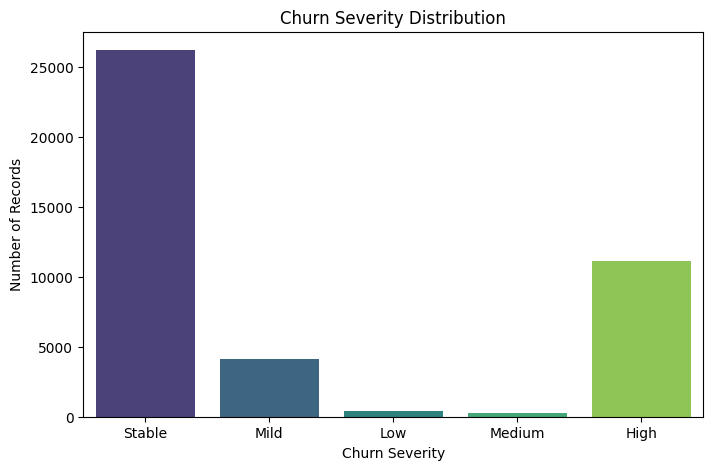

churn_severity
Stable    26205
Mild       4152
Low         414
Medium      241
High      11110
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the order of categories based on updated churn_severity labels
severity_order = ['Stable', 'Mild', 'Low', 'Medium', 'High']

# Plot distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df_with_targets, x='churn_severity', order=severity_order, palette='viridis')
plt.title("Churn Severity Distribution")
plt.xlabel("Churn Severity")
plt.ylabel("Number of Records")
plt.show()

# Display counts in the same order
churn_counts_ordered = df_with_targets['churn_severity'].value_counts().reindex(severity_order)
print(churn_counts_ordered)

In [ ]:
# Filter rows with High churn severity
high_churn = df_with_targets[df_with_targets['churn_severity'] == 'High']

# Group by service provider and list unique years
high_churn_years = high_churn.groupby('service_provider')['year'].unique()
print(high_churn_years)

service_provider
Aircel                                              [2017, 2018, 2013, 2014]
Aircel/Dishnet                                                        [2011]
BSNL                       [2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...
BSNL (VNOs)                                                     [2021, 2022]
Bharti Airtel              [2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...
HFCL                                                      [2010, 2011, 2012]
HFCL Infotel                                                          [2009]
Idea                                                            [2011, 2012]
MTNL                       [2010, 2011, 2012, 2013, 2024, 2025, 2009, 201...
Quadrant                                      [2013, 2014, 2015, 2016, 2017]
Quadrant (HFCL)                                                       [2012]
Reliance                                                        [2009, 2010]
Reliance Communications                             [2015, 

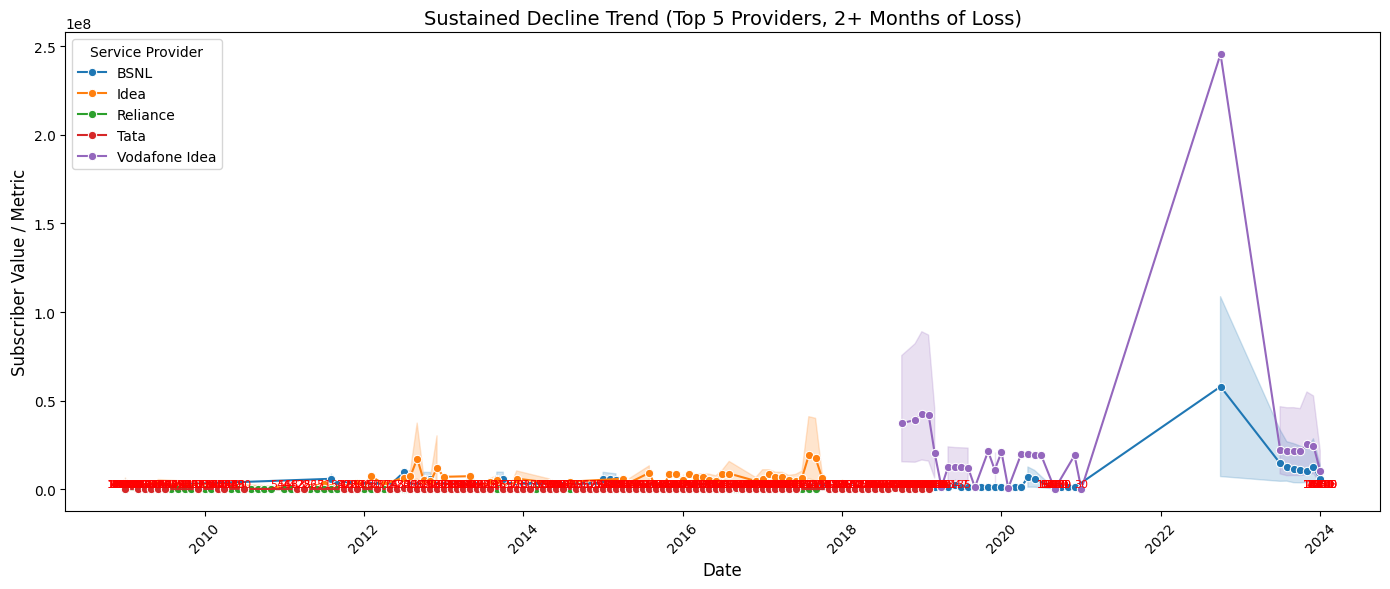

In [ ]:
# Filter only declining trend
trend_df = df_with_targets[df_with_targets['declining_trend']]

# Get top 5 service providers with most declining trend records
top_providers = trend_df['service_provider'].value_counts().head(5).index
trend_top = trend_df[trend_df['service_provider'].isin(top_providers)]

# Set color palette for readability
palette = sns.color_palette("tab10", n_colors=len(top_providers))

plt.figure(figsize=(14,6))
sns.lineplot(
    data=trend_top,
    x='date',
    y='value',
    hue='service_provider',
    marker='o',
    palette=palette
)

plt.title("Sustained Decline Trend (Top 5 Providers, 2+ Months of Loss)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Subscriber Value / Metric", fontsize=12)
plt.xticks(rotation=45)

# Optional: annotate points where decline is particularly high (e.g., value drop below threshold)
threshold = trend_top['value'].quantile(0.2)  # bottom 20% values
for provider in top_providers:
    sub_df = trend_top[(trend_top['service_provider']==provider) & (trend_top['value'] <= threshold)]
    for x, y in zip(sub_df['date'], sub_df['value']):
        plt.text(x, y, f'{int(y)}', fontsize=8, color='red', ha='center', va='bottom')

plt.legend(title='Service Provider')
plt.tight_layout()
plt.show()

* Vodafone Idea (purple) shows large peaks and drops, indicating significant volatility in subscriber counts.

* Tata (red) shows a consistently low trend, meaning their declines were steady but not extreme.

* Some providers (like Reliance, green) appear relatively flat, meaning few large declines.

In [ ]:
df.head()

,year,month,circle,type_of_connection,service_provider,value,date
25066,2024,January,All India,wireline,APSFL,647917.0,2024-01-01
25067,2024,February,All India,wireline,APSFL,643787.0,2024-02-01
25068,2024,March,All India,wireline,APSFL,643593.0,2024-03-01
25069,2024,April,All India,wireline,APSFL,640555.0,2024-04-01
25070,2024,May,All India,wireline,APSFL,639952.0,2024-05-01


## Step 2

In [ ]:
def validate_churn_patterns(df):
    major_operators = ['JIO', 'AIRTEL', 'VI', 'BSNL']

    # Categorize operator as Major vs Regional
    df['operator_category'] = df['service_provider'].apply(
        lambda x: 'Major' if any(op in x.upper() for op in major_operators) else 'Regional'
    )

    # Mean churn by operator category
    churn_by_category = df.groupby('operator_category')['churn'].mean().sort_values(ascending=False)
    print("\n📊 Churn Rate by Operator Category:\n", churn_by_category)

    # Top 10 circles by churn rate
    churn_by_circle = df.groupby('circle')['churn'].mean().sort_values(ascending=False).head(10)
    print("\n📍 Top 10 Circles by Churn Rate:\n", churn_by_circle)

    return df

df_validated = validate_churn_patterns(df_with_targets)


📊 Churn Rate by Operator Category:
 operator_category
Major       0.374802
Regional    0.166784
Name: churn, dtype: float64

📍 Top 10 Circles by Churn Rate:
 circle
Jharkhand               0.444444
Madhya Pradesh          0.316118
Punjab                  0.306840
Uttar Pradesh (East)    0.302377
Maharashtra             0.302083
Andhra Pradesh          0.301667
Rajasthan               0.300104
Delhi                   0.294557
Kolkata                 0.293460
Gujarat                 0.293131
Name: churn, dtype: float64


| Operator Category | Average Churn Rate |
|--------------------|--------------------|
| **Major Operators (JIO, AIRTEL, VI, BSNL)** | **37.48%** |
| **Regional Operators** | **16.68%** |

#### 🔍 Insights:
- Major operators are experiencing a **significantly higher churn rate** compared to regional ones.  
- Despite strong brand presence, **about 1 in 3 customers** of major players are discontinuing service month-over-month.  
- Possible causes:
  - Aggressive competition and frequent plan switching in urban markets.  
  - Market saturation and lower customer stickiness among price-sensitive users.  
- Regional players show **greater customer retention**, possibly due to:
  - Localized focus and loyal user base.  
  - Less aggressive competition in rural areas.
  - **Jharkhand** leads with the highest churn (≈44%), signaling **urgent retention and service quality issues**.  
- States like **Madhya Pradesh, Punjab, and UP (East)** also show churn above 30%, indicating **unstable customer bases**.  
- Even **metro circles (Delhi, Kolkata)** appear in the top churn list — highlighting **intense urban competition**.  
- These regions represent **critical churn hotspots** and need immediate operational review.
#### 💡 Business Takeaway:
- Prioritize churn control initiatives in **Jharkhand, MP, and Punjab** through network improvements or targeted promotions.  
- For urban areas like **Delhi and Kolkata**, focus on **service differentiation** (quality, bundling, digital offers) rather than just pricing.
-Major operators should prioritize **customer retention campaigns**, including loyalty benefits, better network experiences, and regionalized offers to reduce high churn momentum.


## Visualization for step 2

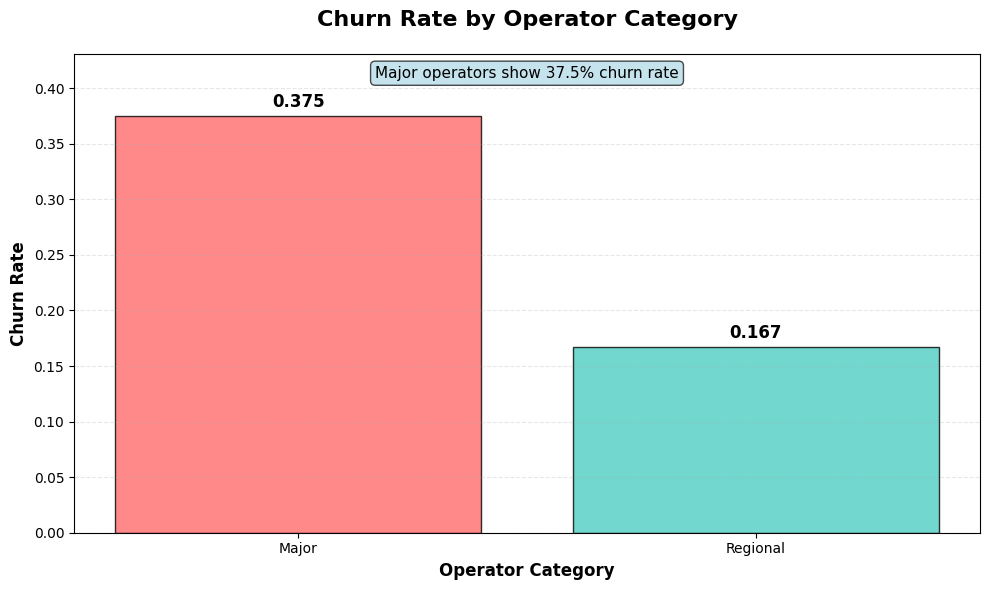

📊 Churn Rate Summary:
Major Operators: 0.375 (37.5%)
Regional Operators: 0.167 (16.7%)
Difference: 0.208 (124.7% higher)


In [ ]:
# Churn Rate by Operator Category Visualization
plt.figure(figsize=(10, 6))

# Create a bar plot for churn rates by operator category
churn_by_category = df_validated.groupby('operator_category')['churn'].mean().sort_values(ascending=False)
colors = ['#ff6b6b', '#4ecdc4']  # Red for Major, Teal for Regional

bars = plt.bar(churn_by_category.index, churn_by_category.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, churn_by_category.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.title('Average Churn Rate by Operator Category', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Operator Category', fontsize=12, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12, fontweight='bold')
plt.ylim(0, max(churn_by_category.values) * 1.15)

# Add grid for better readability
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels
plt.text(0.5, 0.95, f'Major operators show {churn_by_category["Major"]:.1%} churn rate',
         transform=plt.gca().transAxes, ha='center', fontsize=11,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

print(f"📊 Churn Rate Summary:")
print(f"Major Operators: {churn_by_category['Major']:.3f} ({churn_by_category['Major']:.1%})")
print(f"Regional Operators: {churn_by_category['Regional']:.3f} ({churn_by_category['Regional']:.1%})")
print(f"Difference: {churn_by_category['Major'] - churn_by_category['Regional']:.3f} ({((churn_by_category['Major'] - churn_by_category['Regional'])/churn_by_category['Regional']*100):.1f}% higher)")

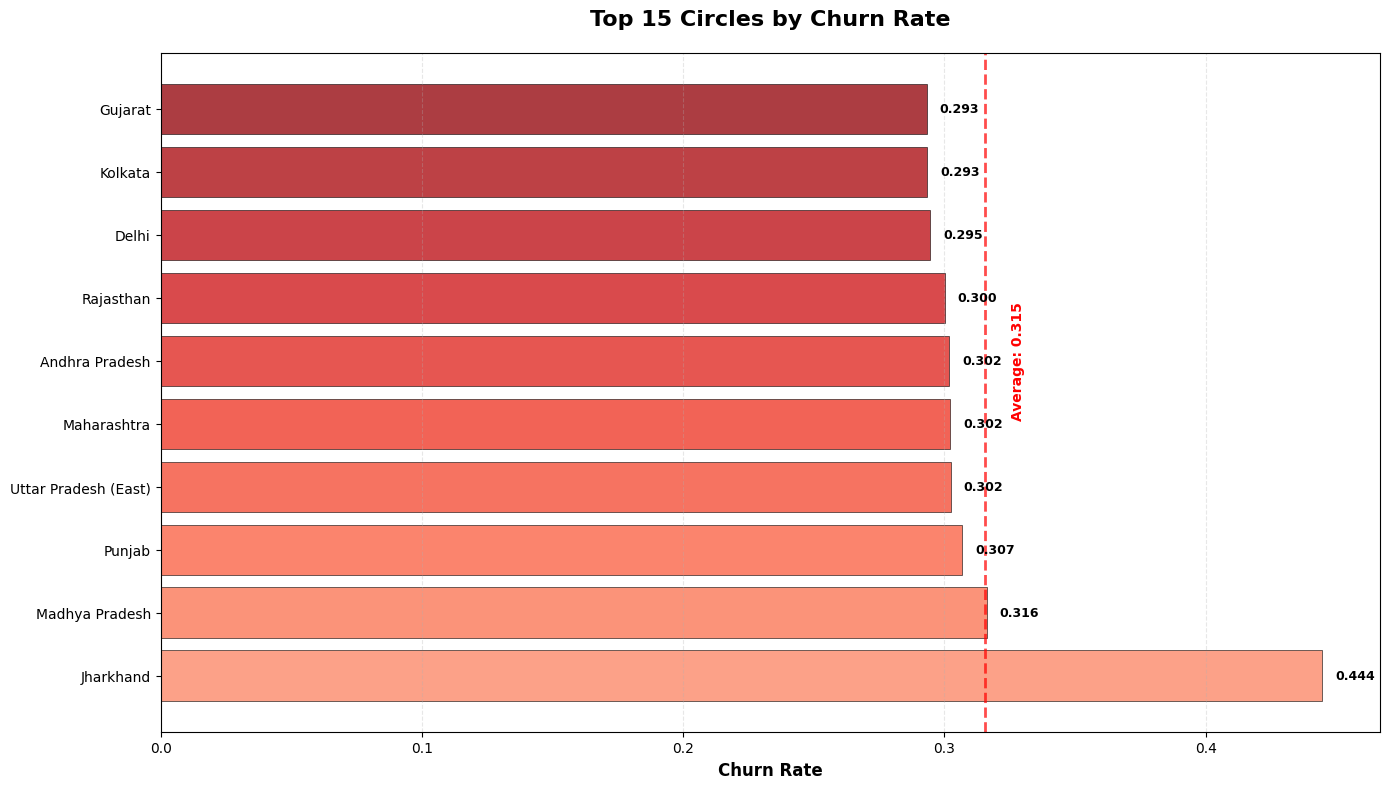

📍 Top 10 Circles Churn Analysis:
Highest Churn: Jharkhand (0.444)
Average Churn (Top 10): 0.315
Range: 0.293 - 0.444


In [ ]:
# Top Circles by Churn Rate Visualization
plt.figure(figsize=(14, 8))

# Get top 10 circles by churn rate
churn_by_circle = df_validated.groupby('circle')['churn'].mean().sort_values(ascending=False).head(10)

# Create color gradient from red (high churn) to yellow (lower churn)
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(churn_by_circle)))

bars = plt.barh(range(len(churn_by_circle)), churn_by_circle.values, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Customize y-axis labels
plt.yticks(range(len(churn_by_circle)), churn_by_circle.index, fontsize=10)
plt.xlabel('Churn Rate', fontsize=12, fontweight='bold')
plt.title('Top 10 Circles by Churn Rate', fontsize=16, fontweight='bold', pad=20)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, churn_by_circle.values)):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', ha='left', va='center', fontweight='bold', fontsize=9)

# Add grid for better readability
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add summary statistics
mean_churn = churn_by_circle.mean()
plt.axvline(x=mean_churn, color='red', linestyle='--', alpha=0.7, linewidth=2)
plt.text(mean_churn + 0.01, len(churn_by_circle)/2, f'Average: {mean_churn:.3f}',
         rotation=90, va='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print(f"📍 Top 10 Circles Churn Analysis:")
print(f"Highest Churn: {churn_by_circle.index[0]} ({churn_by_circle.iloc[0]:.3f})")
print(f"Average Churn (Top 10): {mean_churn:.3f}")
print(f"Range: {churn_by_circle.iloc[-1]:.3f} - {churn_by_circle.iloc[0]:.3f}")

## Step 3

## Create Temporal (Time-Based) Features
### Churn is a temporal event — these features capture momentum, seasonality, and persistence.

In [ ]:
def create_temporal_features(df):
    df_features = df.copy()

    # ----- Lag Features -----
    for lag in [1, 3, 6, 12]:
        df_features[f'subscribers_lag_{lag}'] = (
            df_features.groupby(['service_provider', 'circle'])['value'].shift(lag)
        )

    # ----- Growth Rates -----
    df_features['mom_growth'] = (
        df_features.groupby(['service_provider', 'circle'])['value'].pct_change(periods=1)
    )
    df_features['yoy_growth'] = (
        df_features.groupby(['service_provider', 'circle'])['value'].pct_change(periods=12)
    )

    # ----- Volatility -----
    for window in [3, 6, 12]:
        df_features[f'growth_volatility_{window}'] = (
            df_features.groupby(['service_provider', 'circle'])['mom_growth']
            .rolling(window=window).std().reset_index(level=[0,1], drop=True)
        )

    # ----- Trend Coefficient (slope) -----
    def calc_trend(series):
        y = series.values
        if len(y) < 3 or np.isnan(y).sum() > len(y) - 3:
            return np.nan
        x = np.arange(len(y))
        valid = ~np.isnan(y)
        if valid.sum() < 3:
            return np.nan
        slope = np.polyfit(x[valid], y[valid], 1)[0]
        return slope

    df_features['trend_12m'] = (
        df_features.groupby(['service_provider', 'circle'])['value']
        .rolling(window=12, min_periods=3).apply(calc_trend)
        .reset_index(level=[0,1], drop=True)
    )

    print("✅ Temporal features created successfully.")
    return df_features

df_temporal_features = create_temporal_features(df_validated)
print("New shape after temporal features:", df_temporal_features.shape)
df_temporal_features.head()

✅ Temporal features created successfully.
New shape after temporal features: (42122, 22)


,year,month,circle,type_of_connection,service_provider,value,date,subscriber_change,churn,churn_severity,...,subscribers_lag_1,subscribers_lag_3,subscribers_lag_6,subscribers_lag_12,mom_growth,yoy_growth,growth_volatility_3,growth_volatility_6,growth_volatility_12,trend_12m
25066,2024,January,All India,wireline,APSFL,647917.0,2024-01-01,0.000000,0,Stable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25067,2024,February,All India,wireline,APSFL,643787.0,2024-02-01,-0.006374,0,Mild,...,647917.0,NaN,NaN,NaN,-0.006374,NaN,NaN,NaN,NaN,NaN
25068,2024,March,All India,wireline,APSFL,643593.0,2024-03-01,-0.000301,0,Mild,...,643787.0,NaN,NaN,NaN,-0.000301,NaN,NaN,NaN,NaN,-2162.0
25069,2024,April,All India,wireline,APSFL,640555.0,2024-04-01,-0.004720,0,Mild,...,643593.0,647917.0,NaN,NaN,-0.004720,NaN,0.003140,NaN,NaN,-2228.0
25070,2024,May,All India,wireline,APSFL,639952.0,2024-05-01,-0.000941,0,Mild,...,640555.0,643787.0,NaN,NaN,-0.000941,NaN,0.002388,NaN,NaN,-1916.2


In [ ]:
df_temporal_features['service_provider'].unique()

array(['APSFL', 'Aircel', 'Aircel/Dishnet', 'BPL Mobile', 'BSNL',
       'BSNL (VNOs)', 'Bharti Airtel',
       'Bharti Airtel (Including Tata Tele.)',
       'Bharti Airtel (including Tata Telecommunications)', 'Etisalat',
       'Etisalat/Allianz', 'HFCL', 'HFCL Infotel', 'Idea', 'Idea/Spice',
       'Loop', 'Loop Telecom Pvt. Ltd.', 'MTNL', 'Quadrant',
       'Quadrant (HFCL)', 'Reliance', 'Reliance Communications',
       'Reliance Jio', 'S-Tel', 'Sistema',
       'Sistema Shyam Teleservices Ltd', 'Spice',
       'Systema Shyam Teleservices Ltd.', 'Tata', 'Tata Teleservices',
       'Telenor', 'Teleservice Ltd.', 'Uninor', 'Unitech',
       'V-CON Mobile & Infra Pvt. Ltd.', 'Videocon', 'Vodafone',
       'Vodafone Essar', 'Vodafone Idea'], dtype=object)

/tmp/ipython-input-543590423.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


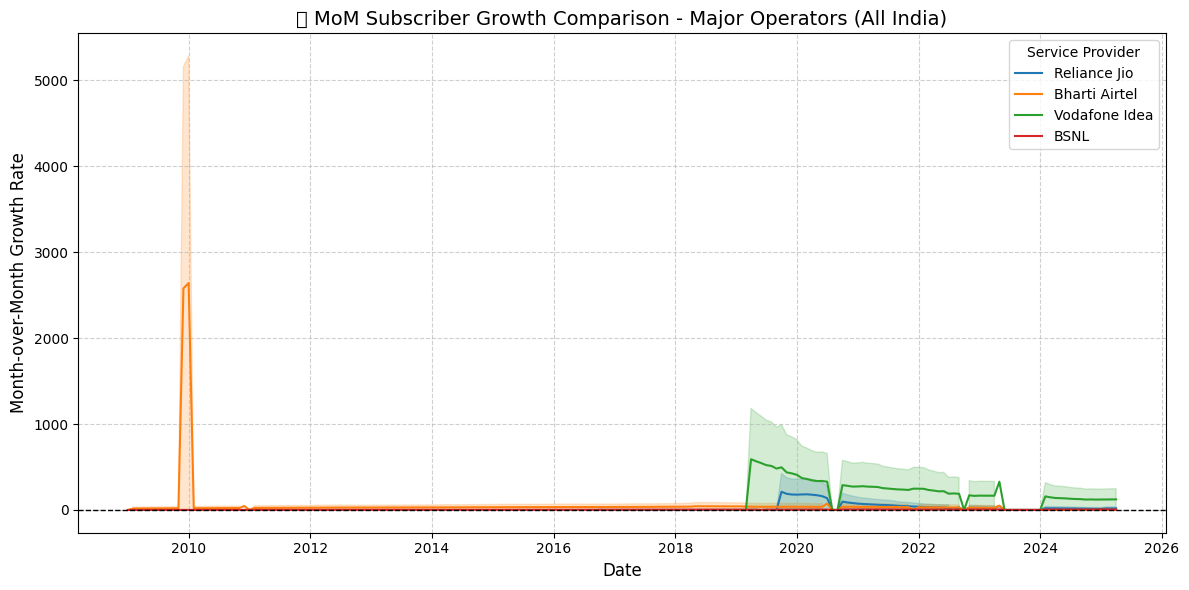

In [ ]:
# Define the circle and major operators
circle_name = 'All India'
major_operators = ['Reliance Jio', 'Bharti Airtel', 'Vodafone Idea', 'BSNL']

plt.figure(figsize=(12,6))

# Loop through each major operator and plot its MoM growth trend
for p in major_operators:
    temp = df_temporal_features[
        (df_temporal_features['service_provider'].str.contains(p, case=False, na=False)) &
        (df_temporal_features['circle'] == circle_name)
    ]
    if not temp.empty:
        sns.lineplot(data=temp, x='date', y='mom_growth', label=p)

# Reference line at 0% growth
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Titles and labels
plt.title(f"📈 MoM Subscriber Growth Comparison - Major Operators ({circle_name})", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Month-over-Month Growth Rate", fontsize=12)
plt.legend(title="Service Provider")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2465908334.py:33: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


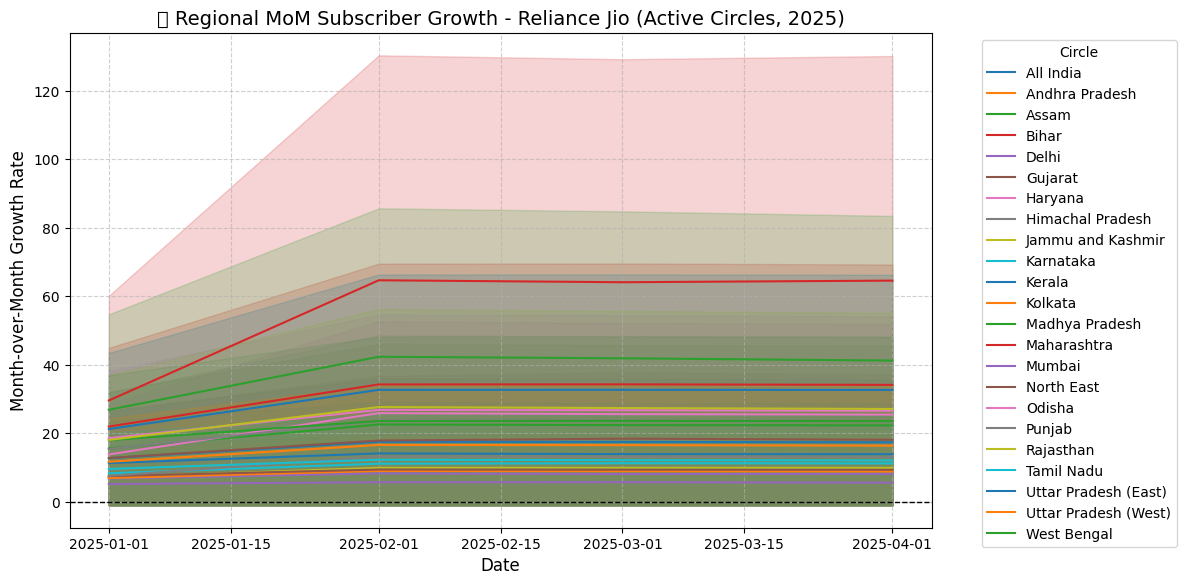

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the provider and filter only 2025 data
provider = 'Reliance Jio'

# Filter dataset for 2025 and that specific provider
jio_2025 = df_temporal_features[
    (df_temporal_features['service_provider'].str.contains(provider, case=False, na=False)) &
    (df_temporal_features['year'] == 2025)
]

# Extract circles where Jio is active in 2025
active_circles = jio_2025['circle'].unique()

plt.figure(figsize=(12,6))

# Plot MoM growth for each active circle
for c in active_circles:
    temp = jio_2025[jio_2025['circle'] == c]
    if not temp.empty:
        sns.lineplot(data=temp, x='date', y='mom_growth', label=c)

# Add reference line for neutral growth
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Chart aesthetics
plt.title(f"📍 Regional MoM Subscriber Growth - {provider} (Active Circles, 2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Month-over-Month Growth Rate", fontsize=12)
plt.legend(title="Circle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Year-over-Year (YoY) Growth Comparison

- Similar to MoM, but shows long-term trends across operators or circles.

- Helps identify seasonal or annual retention issues.

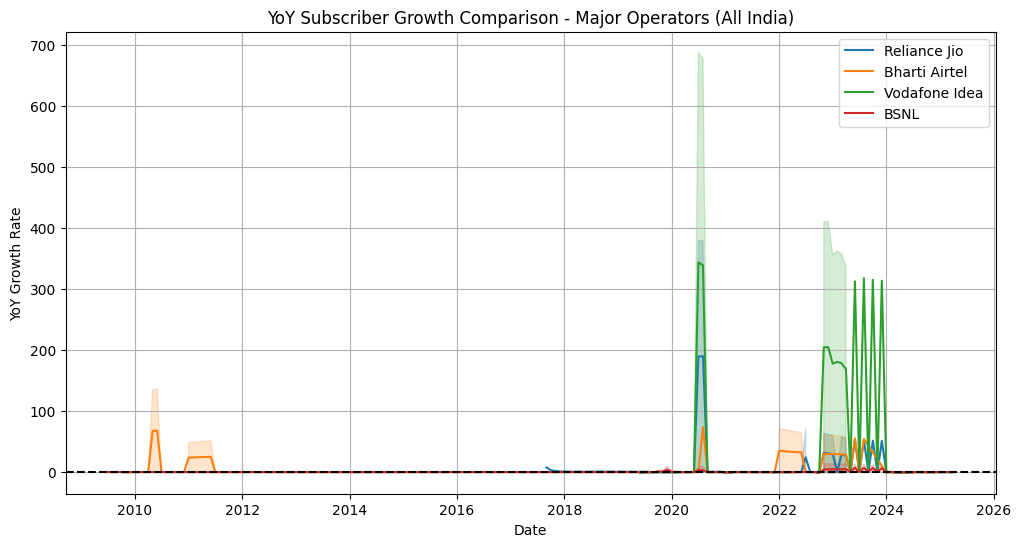

In [ ]:
circle_name = 'All India'
major_operators = ['Reliance Jio', 'Bharti Airtel', 'Vodafone Idea', 'BSNL']
# Cross-operator YoY growth for All India
plt.figure(figsize=(12,6))
for p in major_operators:
    temp = df_temporal_features[
        (df_temporal_features['service_provider'].str.contains(p, case=False, na=False)) &
        (df_temporal_features['circle'] == circle_name)
    ]
    if not temp.empty:
        sns.lineplot(data=temp, x='date', y='yoy_growth', label=p)

plt.axhline(0, color='black', linestyle='--')
plt.title(f"YoY Subscriber Growth Comparison - Major Operators ({circle_name})")
plt.xlabel("Date"); plt.ylabel("YoY Growth Rate")
plt.legend(); plt.grid(True); plt.show()

## Growth Volatility Analysis

- Measures stability of subscriber growth (3, 6, 12 months).

- High volatility → unstable market → higher churn risk.

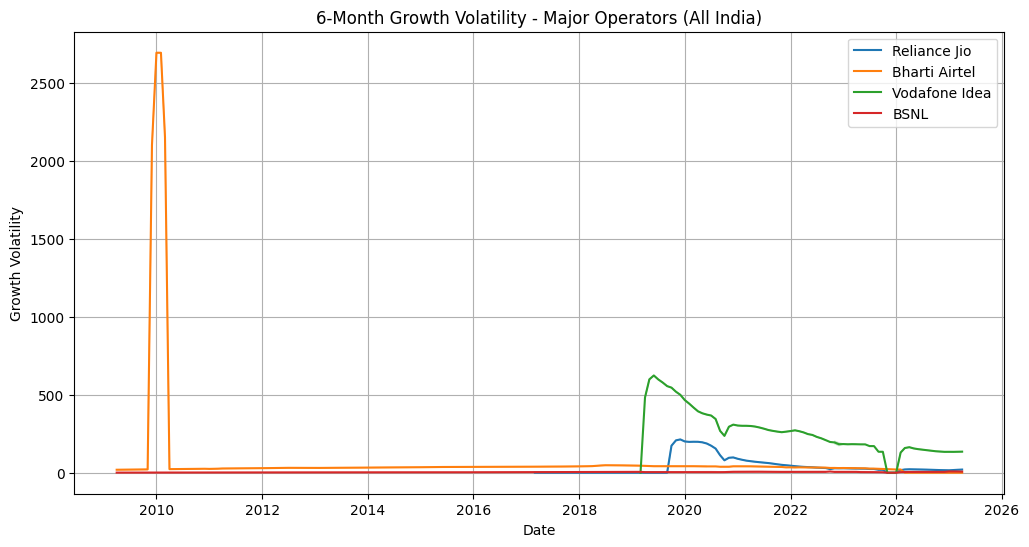

In [ ]:
plt.figure(figsize=(12,6))
for p in major_operators:
    temp = df_temporal_features[
        (df_temporal_features['service_provider'].str.contains(p, case=False, na=False)) &
        (df_temporal_features['circle'] == circle_name)
    ]
    if not temp.empty:
        sns.lineplot(data=temp, x='date', y='growth_volatility_6', label=p)

plt.title(f"6-Month Growth Volatility - Major Operators ({circle_name})")
plt.xlabel("Date"); plt.ylabel("Growth Volatility")
plt.legend(); plt.grid(True); plt.show()

## Heatmap: Correlation Between Features and Churn

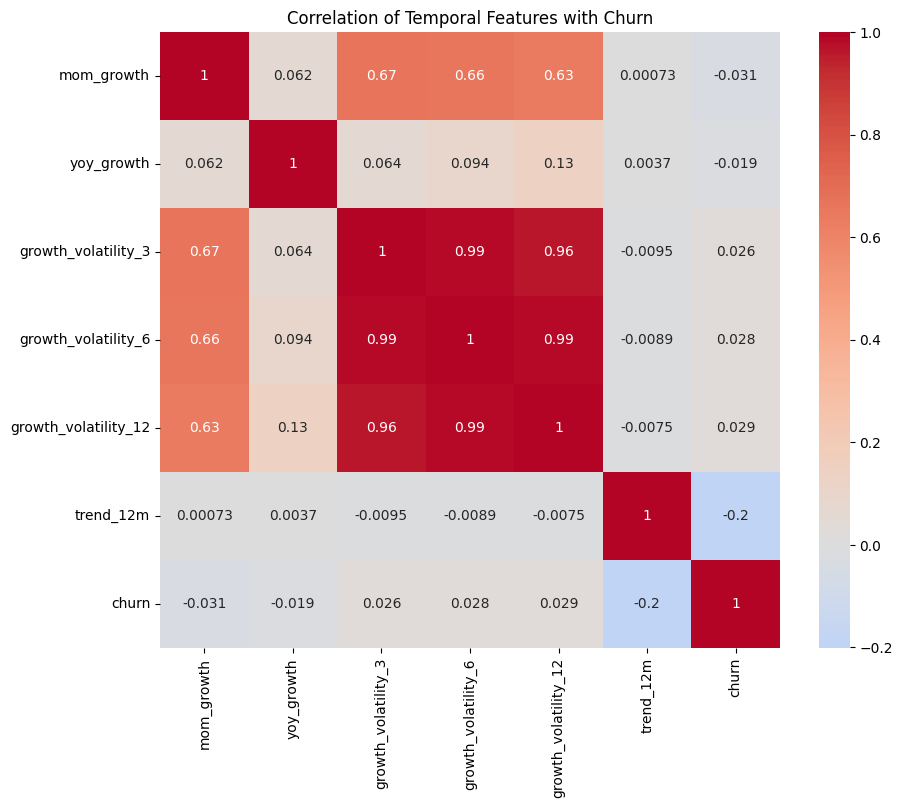

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ['mom_growth','yoy_growth','growth_volatility_3','growth_volatility_6','growth_volatility_12','trend_12m','churn']
plt.figure(figsize=(10,8))
sns.heatmap(df_temporal_features[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Temporal Features with Churn")
plt.show()

## Step 4

## Competitive & Market Features
### To capture how each operator is performing relative to competitors in the same telecom circle and month.
###Churn is not only about decline — it’s often caused by competitive pressure (competitor gain, market gap widening, etc.).

In [ ]:
def create_competitive_features(df):
    df_comp = df.copy()

    # ----- 1️⃣ Market Share -----
    df_comp['market_share'] = df_comp.groupby(['circle', 'date'])['value'].transform(
        lambda x: x / x.sum()
    )

    # ----- 2️⃣ Market Rank (1 = leader) -----
    df_comp['market_rank'] = df_comp.groupby(['circle', 'date'])['market_share'].rank(
        ascending=False, method='dense'
    )

    # ----- 3️⃣ Share Gap from Market Leader -----
    leader_share = df_comp.groupby(['circle', 'date'])['market_share'].transform('max')
    df_comp['share_gap_leader'] = leader_share - df_comp['market_share']

    # ----- 4️⃣ Relative Performance vs Circle Average -----
    circle_avg = df_comp.groupby(['circle', 'date'])['value'].transform('mean')
    df_comp['relative_performance'] = df_comp['value'] / circle_avg

    # ----- 5️⃣ Market Concentration (HHI proxy) -----
    hhi_df = (
        df_comp.groupby(['circle', 'date'])['market_share']
        .apply(lambda x: np.sum(x**2))
        .reset_index(name='circle_hhi')
    )

    df_comp = df_comp.merge(hhi_df, on=['circle', 'date'], how='left')

    print("✅ Competitive features created successfully.")
    return df_comp


df_competitive_features = create_competitive_features(df_temporal_features)
print("New shape after competitive features:", df_competitive_features.shape)
df_competitive_features.head()

✅ Competitive features created successfully.
New shape after competitive features: (42122, 27)


,year,month,circle,type_of_connection,service_provider,value,date,subscriber_change,churn,churn_severity,...,yoy_growth,growth_volatility_3,growth_volatility_6,growth_volatility_12,trend_12m,market_share,market_rank,share_gap_leader,relative_performance,circle_hhi
0,2024,January,All India,wireline,APSFL,647917.0,2024-01-01,0.000000,0,Stable,...,NaN,NaN,NaN,NaN,NaN,0.000544,11.0,0.389200,0.007075,0.295714
1,2024,February,All India,wireline,APSFL,643787.0,2024-02-01,-0.006374,0,Mild,...,NaN,NaN,NaN,NaN,NaN,0.000539,11.0,0.390764,0.007004,0.296351
2,2024,March,All India,wireline,APSFL,643593.0,2024-03-01,-0.000301,0,Mild,...,NaN,NaN,NaN,NaN,-2162.0,0.000538,11.0,0.392065,0.006993,0.297457
3,2024,April,All India,wireline,APSFL,640555.0,2024-04-01,-0.004720,0,Mild,...,NaN,0.003140,NaN,NaN,-2228.0,0.000535,11.0,0.393691,0.006949,0.298318
4,2024,May,All India,wireline,APSFL,639952.0,2024-05-01,-0.000941,0,Mild,...,NaN,0.002388,NaN,NaN,-1916.2,0.000533,11.0,0.394716,0.006928,0.298880


#### Measures market concentration:

#### HHI near 1.0 → one or two dominant players (less competition).

#### HHI near 0.25 or below → highly competitive market.

## Visualization for step 4

## Market Share Trends

- Purpose: See how each operator’s share evolves over time within a circle.

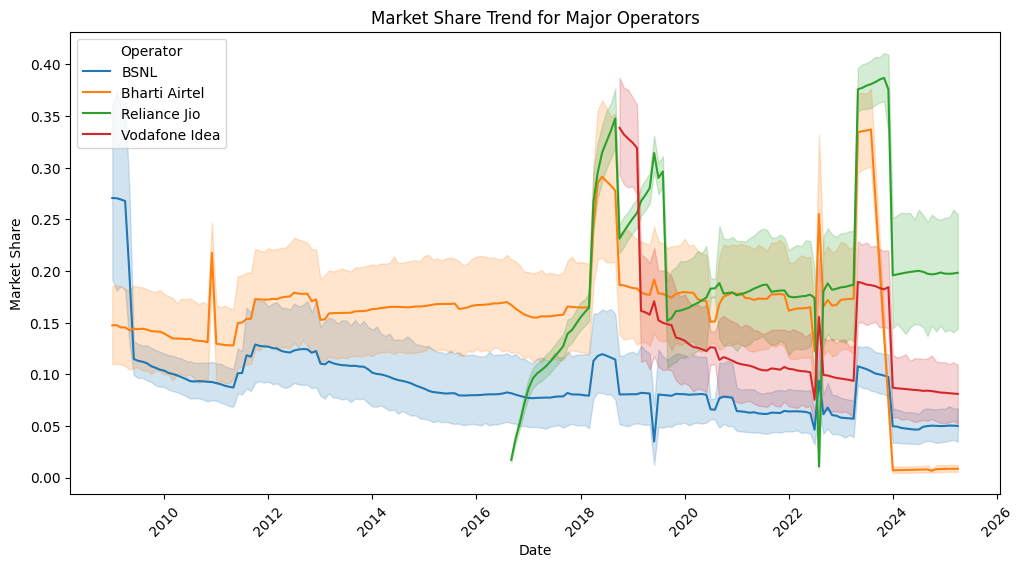

In [ ]:
# Filter data for major operators
df_major = df_competitive_features[df_competitive_features['service_provider'].isin(major_operators)]

# Plot market share trend for major operators
plt.figure(figsize=(12,6))
sns.lineplot(data=df_major, x='date', y='market_share', hue='service_provider')
plt.title("Market Share Trend for Major Operators")
plt.ylabel("Market Share")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title="Operator")
plt.show()

- Reliance Jio (green) rises sharply around 2016–2018, overtaking competitors.

- Bharti Airtel and Vodafone Idea fluctuate but remain relatively stable before Jio’s entry.

- BSNL shows a steady decline in market share over the years.
- Operators losing market share consistently (BSNL, Vodafone Idea at times) are more likely to experience subscriber churn.

## Market Rank Distribution

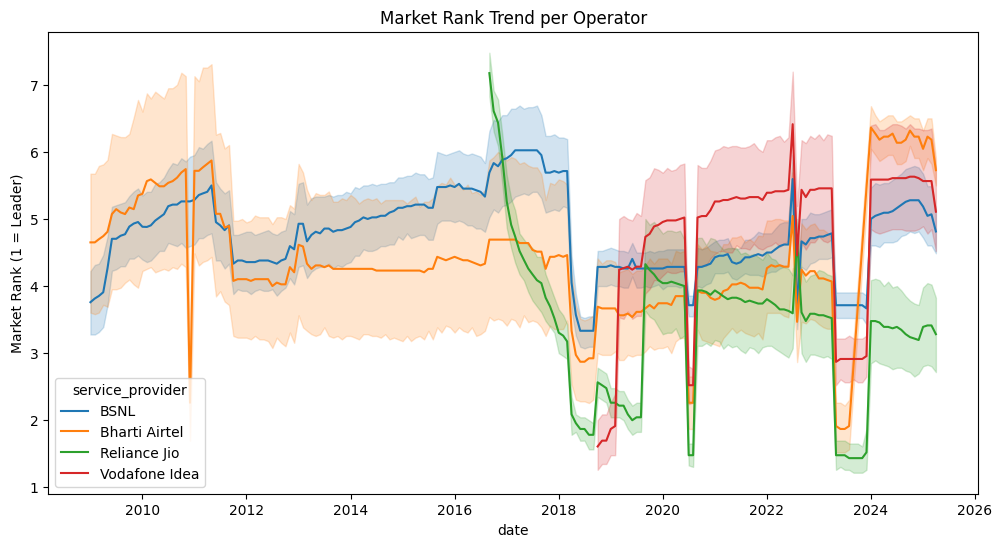

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_major, x='date', y='market_rank', hue='service_provider')
plt.title("Market Rank Trend per Operator")
plt.ylabel("Market Rank (1 = Leader)")
plt.show()

## Step 5

## Business & Contextual Features
### To enrich the dataset with domain-aware context, so your churn model can interpret patterns based on market type, connection form, and operator diversity.

In [ ]:
def create_business_features(df):
    df_biz = df.copy()

    # ----- 1️⃣ Circle Classification (Metro vs Non-Metro) -----
    metro_circles = ['Delhi', 'Mumbai', 'Chennai', 'Kolkata', 'Hyderabad', 'Bangalore']
    df_biz['circle_type'] = df_biz['circle'].apply(
        lambda x: 'Metro' if x in metro_circles else 'Non-Metro'
    )

    # ----- 2️⃣ Connection Type (Wireless vs Wireline) -----
    df_biz['is_wireless'] = (
        df_biz['type_of_connection'].str.lower().eq('wireless').astype(int)
        if 'type_of_connection' in df_biz.columns else np.nan
    )

    # ----- 3️⃣ Market Size Category (Total Circle Subscribers) -----
    total_market_size = df_biz.groupby('circle')['value'].sum().rank(pct=True)
    df_biz['market_size_category'] = df_biz['circle'].map(total_market_size)

    # ----- 4️⃣ Operator Geographic Diversity (# of Circles they operate in) -----
    operator_circle_count = df_biz.groupby('service_provider')['circle'].nunique()
    df_biz['operator_geographic_diversity'] = df_biz['service_provider'].map(operator_circle_count)

    print("✅ Business & contextual features created successfully.")
    return df_biz


df_all_features = create_business_features(df_competitive_features)
print("Final shape after all feature creation:", df_all_features.shape)
df_all_features.head()

✅ Business & contextual features created successfully.
Final shape after all feature creation: (42122, 31)


,year,month,circle,type_of_connection,service_provider,value,date,subscriber_change,churn,churn_severity,...,trend_12m,market_share,market_rank,share_gap_leader,relative_performance,circle_hhi,circle_type,is_wireless,market_size_category,operator_geographic_diversity
0,2024,January,All India,wireline,APSFL,647917.0,2024-01-01,0.000000,0,Stable,...,NaN,0.000544,11.0,0.389200,0.007075,0.295714,Non-Metro,0,1.0,2
1,2024,February,All India,wireline,APSFL,643787.0,2024-02-01,-0.006374,0,Mild,...,NaN,0.000539,11.0,0.390764,0.007004,0.296351,Non-Metro,0,1.0,2
2,2024,March,All India,wireline,APSFL,643593.0,2024-03-01,-0.000301,0,Mild,...,-2162.0,0.000538,11.0,0.392065,0.006993,0.297457,Non-Metro,0,1.0,2
3,2024,April,All India,wireline,APSFL,640555.0,2024-04-01,-0.004720,0,Mild,...,-2228.0,0.000535,11.0,0.393691,0.006949,0.298318,Non-Metro,0,1.0,2
4,2024,May,All India,wireline,APSFL,639952.0,2024-05-01,-0.000941,0,Mild,...,-1916.2,0.000533,11.0,0.394716,0.006928,0.298880,Non-Metro,0,1.0,2


## Visualization step 5

## Circle Type (Metro vs Non-Metro)

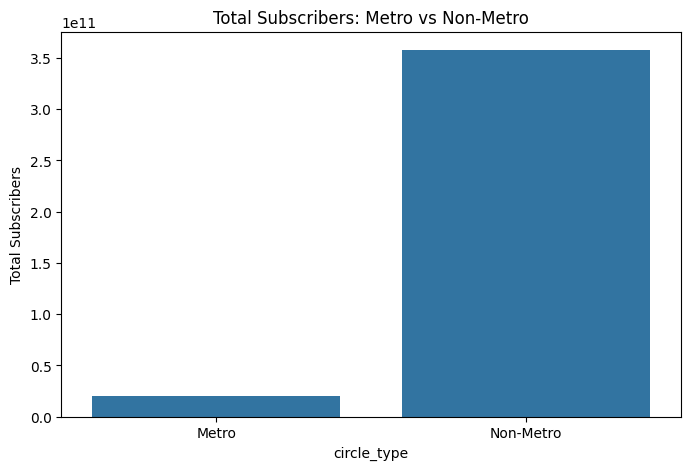

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_all_features.groupby('circle_type')['value'].sum().reset_index(),
            x='circle_type', y='value')
plt.title("Total Subscribers: Metro vs Non-Metro")
plt.ylabel("Total Subscribers")
plt.show()


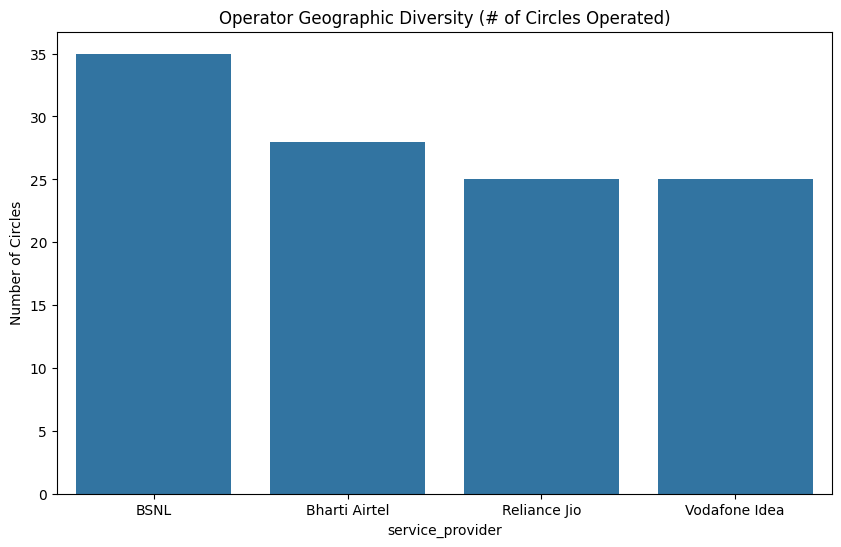

In [ ]:
# Filter data for major operators
df_major2 = df_all_features[df_all_features['service_provider'].isin(major_operators)]


plt.figure(figsize=(10,6))
sns.barplot(data=df_major2.groupby('service_provider')['operator_geographic_diversity'].first().reset_index(),
            x='service_provider', y='operator_geographic_diversity')
plt.title("Operator Geographic Diversity (# of Circles Operated)")
plt.ylabel("Number of Circles")
plt.show()

- BSNL covers 35 circles, which is higher than all other operators.
- Bharti Airtel operates in 28 circles, slightly fewer than BSNL
- Operators with greater geographic diversity (BSNL, Airtel) potentially have a larger market reach and can capture more subscribers.

- Operators with fewer circles (Jio, Vodafone Idea) may focus on densely populated or profitable circles rather than blanket coverage.

In [ ]:
df_all_features.to_csv('df_all_features.csv',index=False)

In [ ]:
files.download('df_all_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>